In [2]:
import ast
import requests
import os
import sys
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import nglview as nv
import py3Dmol
import plotly.graph_objects as go
import torch
from plotly.subplots import make_subplots
from datastory_plots import *
import seaborn as sns

In [3]:
print("Started loading data")
df_mutants = pd.read_csv('../data/mutants.csv')
df_merged = pd.read_csv('../data/merged_df.csv')
df_mutants['Target Names'] = df_mutants['Target Names'].apply(lambda x: ast.literal_eval(x))
df_mutants['BindingDB Target Chain Sequence'] = df_mutants['BindingDB Target Chain Sequence'].apply(lambda x: ast.literal_eval(x))
print("Loaded data")

Started loading data
Loaded data


In [4]:
interaction_pairs = save_dfs_ligands(df_merged, df_mutants)

Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------


Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------
For this ligand-protein pair there are multiple values of IC50 and we decided to drop this case.
This pair will not be saved due to multiple conflicting values in BindingDB
---------------------------------------------------------------------------


Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------


Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------


Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------
For this ligand-protein pair there are multiple values of IC50 and we decided to drop this case.
This pair will not be saved due to multiple conflicting values in BindingDB
---------------------------------------------------------------------------


In [5]:
interaction_pairs.to_csv('../data/interaction_pairs.csv')
print("Saved dfs")

Saved dfs


In [ ]:
visualize_ligands(interaction_pairs['Ligand SMILES'])
print("Saved ligand representations")

Saved ligand representations


[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()
[18:30:36] Molecule does not have explicit Hs. Consider calling AddHs()


In [12]:
generate_interactive_ic50_plot()
print("Saved interactive IC50 plot")

Saved interactive IC50 plot


In [125]:
def old_visualize_mutants(interaction_pairs_path, df_folder, pdb_files_folder):
    mutants_infos = {}
    interaction_pairs = pd.read_csv(interaction_pairs_path)
    for idx, file_name in enumerate(sorted(os.listdir(df_folder))):
        df = pd.read_csv(os.path.join(df_folder, file_name))
        wt_protein_name = interaction_pairs.iloc[idx]['WT protein']
        view = nv.show_file(os.path.join(pdb_files_folder, f'{wt_protein_name}.pdb'))
        curr_num_mutants, curr_mutant_names = mutants_infos[wt_protein_name] if wt_protein_name in mutants_infos.keys() else (0, [])

        saving_folder = f"../plots/{wt_protein_name}"
        if not os.path.exists(saving_folder):
            os.makedirs(saving_folder)
        saving_path = os.path.join(saving_folder, f'{wt_protein_name}_mutant_0.html')
        nv.write_html(saving_path, [view])
        for c in ['Insertion Positions', 'Deletion Positions', 'Substitution Positions']:
            df[c] = df[c].apply(lambda x: [int(i) for i in x.strip('[]').split(' ') if i != '' ])
        for _, row in df.iterrows():
            if row['Mutant Name'] in curr_mutant_names:
                print("Mutant viz already saved")
            else:
                curr_num_mutants+=1
                view.clear_representations()
                view.add_cartoon(color="#D3D3D3")
                view.add_cartoon(row['Insertion Positions'], color="blue")
                view.add_cartoon(range(1,150), color="blue")
                view.add_cartoon(row['Deletion Positions'], color="red")   
                view.add_ball_and_stick(row['Substitution Positions'], color="green")

                saving_path = os.path.join(saving_folder, f'{wt_protein_name}_mutant_{curr_num_mutants}.html')
                nv.write_html(saving_path, [view])
                curr_mutant_names.append(row['Mutant Name'])
        mutants_infos.update({wt_protein_name: (curr_num_mutants, curr_mutant_names)})

    return mutants_infos

In [6]:
mutants_infos = visualize_mutants('../data/interaction_pairs.csv', '../data/prot_viz', '../data/pdb_files')
for k, v in mutants_infos.items():
    pd.DataFrame(v[1]).to_csv(f'../plots/{k}/mutant_names.csv')

Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved
Mutant viz already saved


In [47]:
def bar_plot(interaction_pairs_path, df_folder):
    interaction_pairs = pd.read_csv(interaction_pairs_path)
    mega_df = []
    for idx, file_name in enumerate(sorted(os.listdir(df_folder))):
        df = pd.read_csv(os.path.join(df_folder, file_name))
        df = df[['Mutant Name', 'IC50 Log Ratio']]
        df['WT protein'] = interaction_pairs.iloc[idx]['WT protein']
        df['Ligand SMILES'] = interaction_pairs.iloc[idx]['Ligand SMILES']
        df['Ligand name'] = interaction_pairs.iloc[idx]['Ligand name']
        df['Ligand number'] = idx+1
        mega_df.append(df)

    df_grouped = pd.concat(mega_df, ignore_index=True).groupby(['WT protein', 'Mutant Name'])[['Ligand number', 'IC50 Log Ratio']].agg(list).reset_index()
    df_grouped['Mutant Name'] = df_grouped['Mutant Name'].apply(lambda x: x.split(' ')[1])
    return df_grouped[df_grouped['Ligand number'].apply(len) >=2].explode(['Ligand number', 'IC50 Log Ratio'])

In [48]:
df_test = bar_plot('../data/interaction_pairs.csv', '../data/prot_viz')
df_test.head()

,WT protein,Mutant Name,Ligand number,IC50 Log Ratio
0,EGFR_HUMAN,"[1-18,20-1210,C797S]",1,0.894433
0,EGFR_HUMAN,"[1-18,20-1210,C797S]",2,0.278754
0,EGFR_HUMAN,"[1-18,20-1210,C797S]",3,-0.934498
1,EGFR_HUMAN,"[1-18,20-1210,T790M,C797S]",1,0.680288
1,EGFR_HUMAN,"[1-18,20-1210,T790M,C797S]",2,2.906874


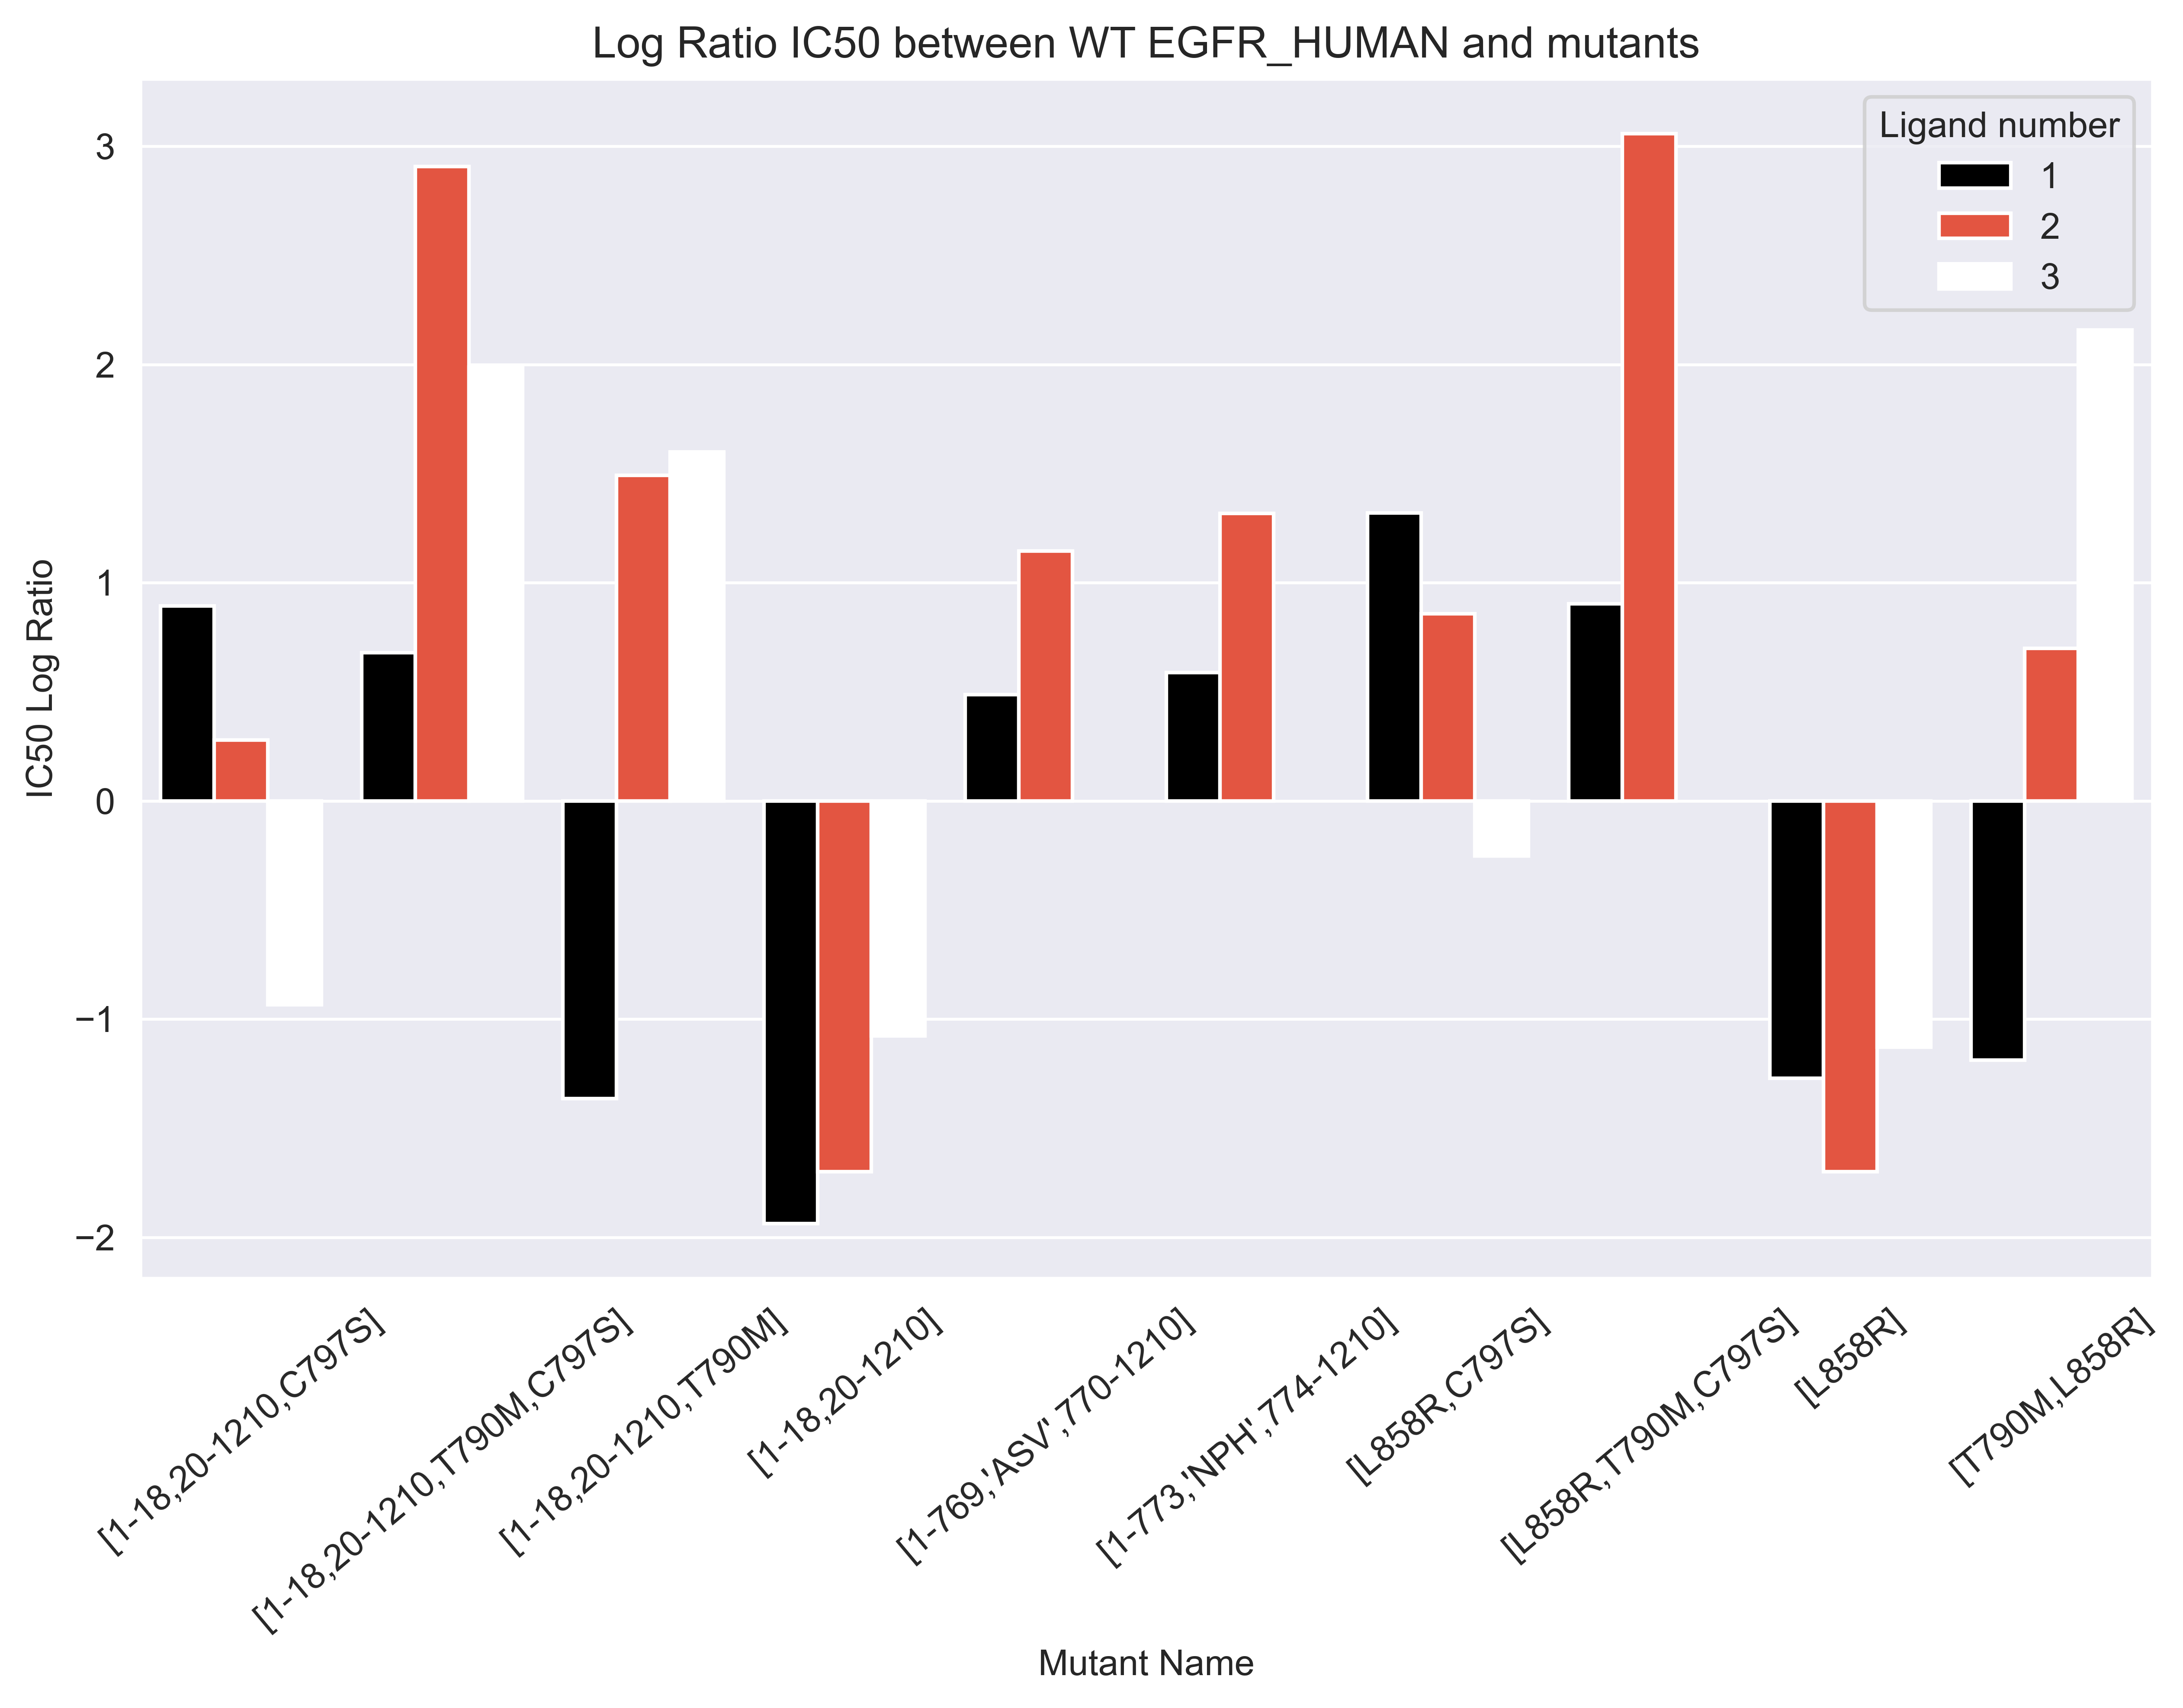

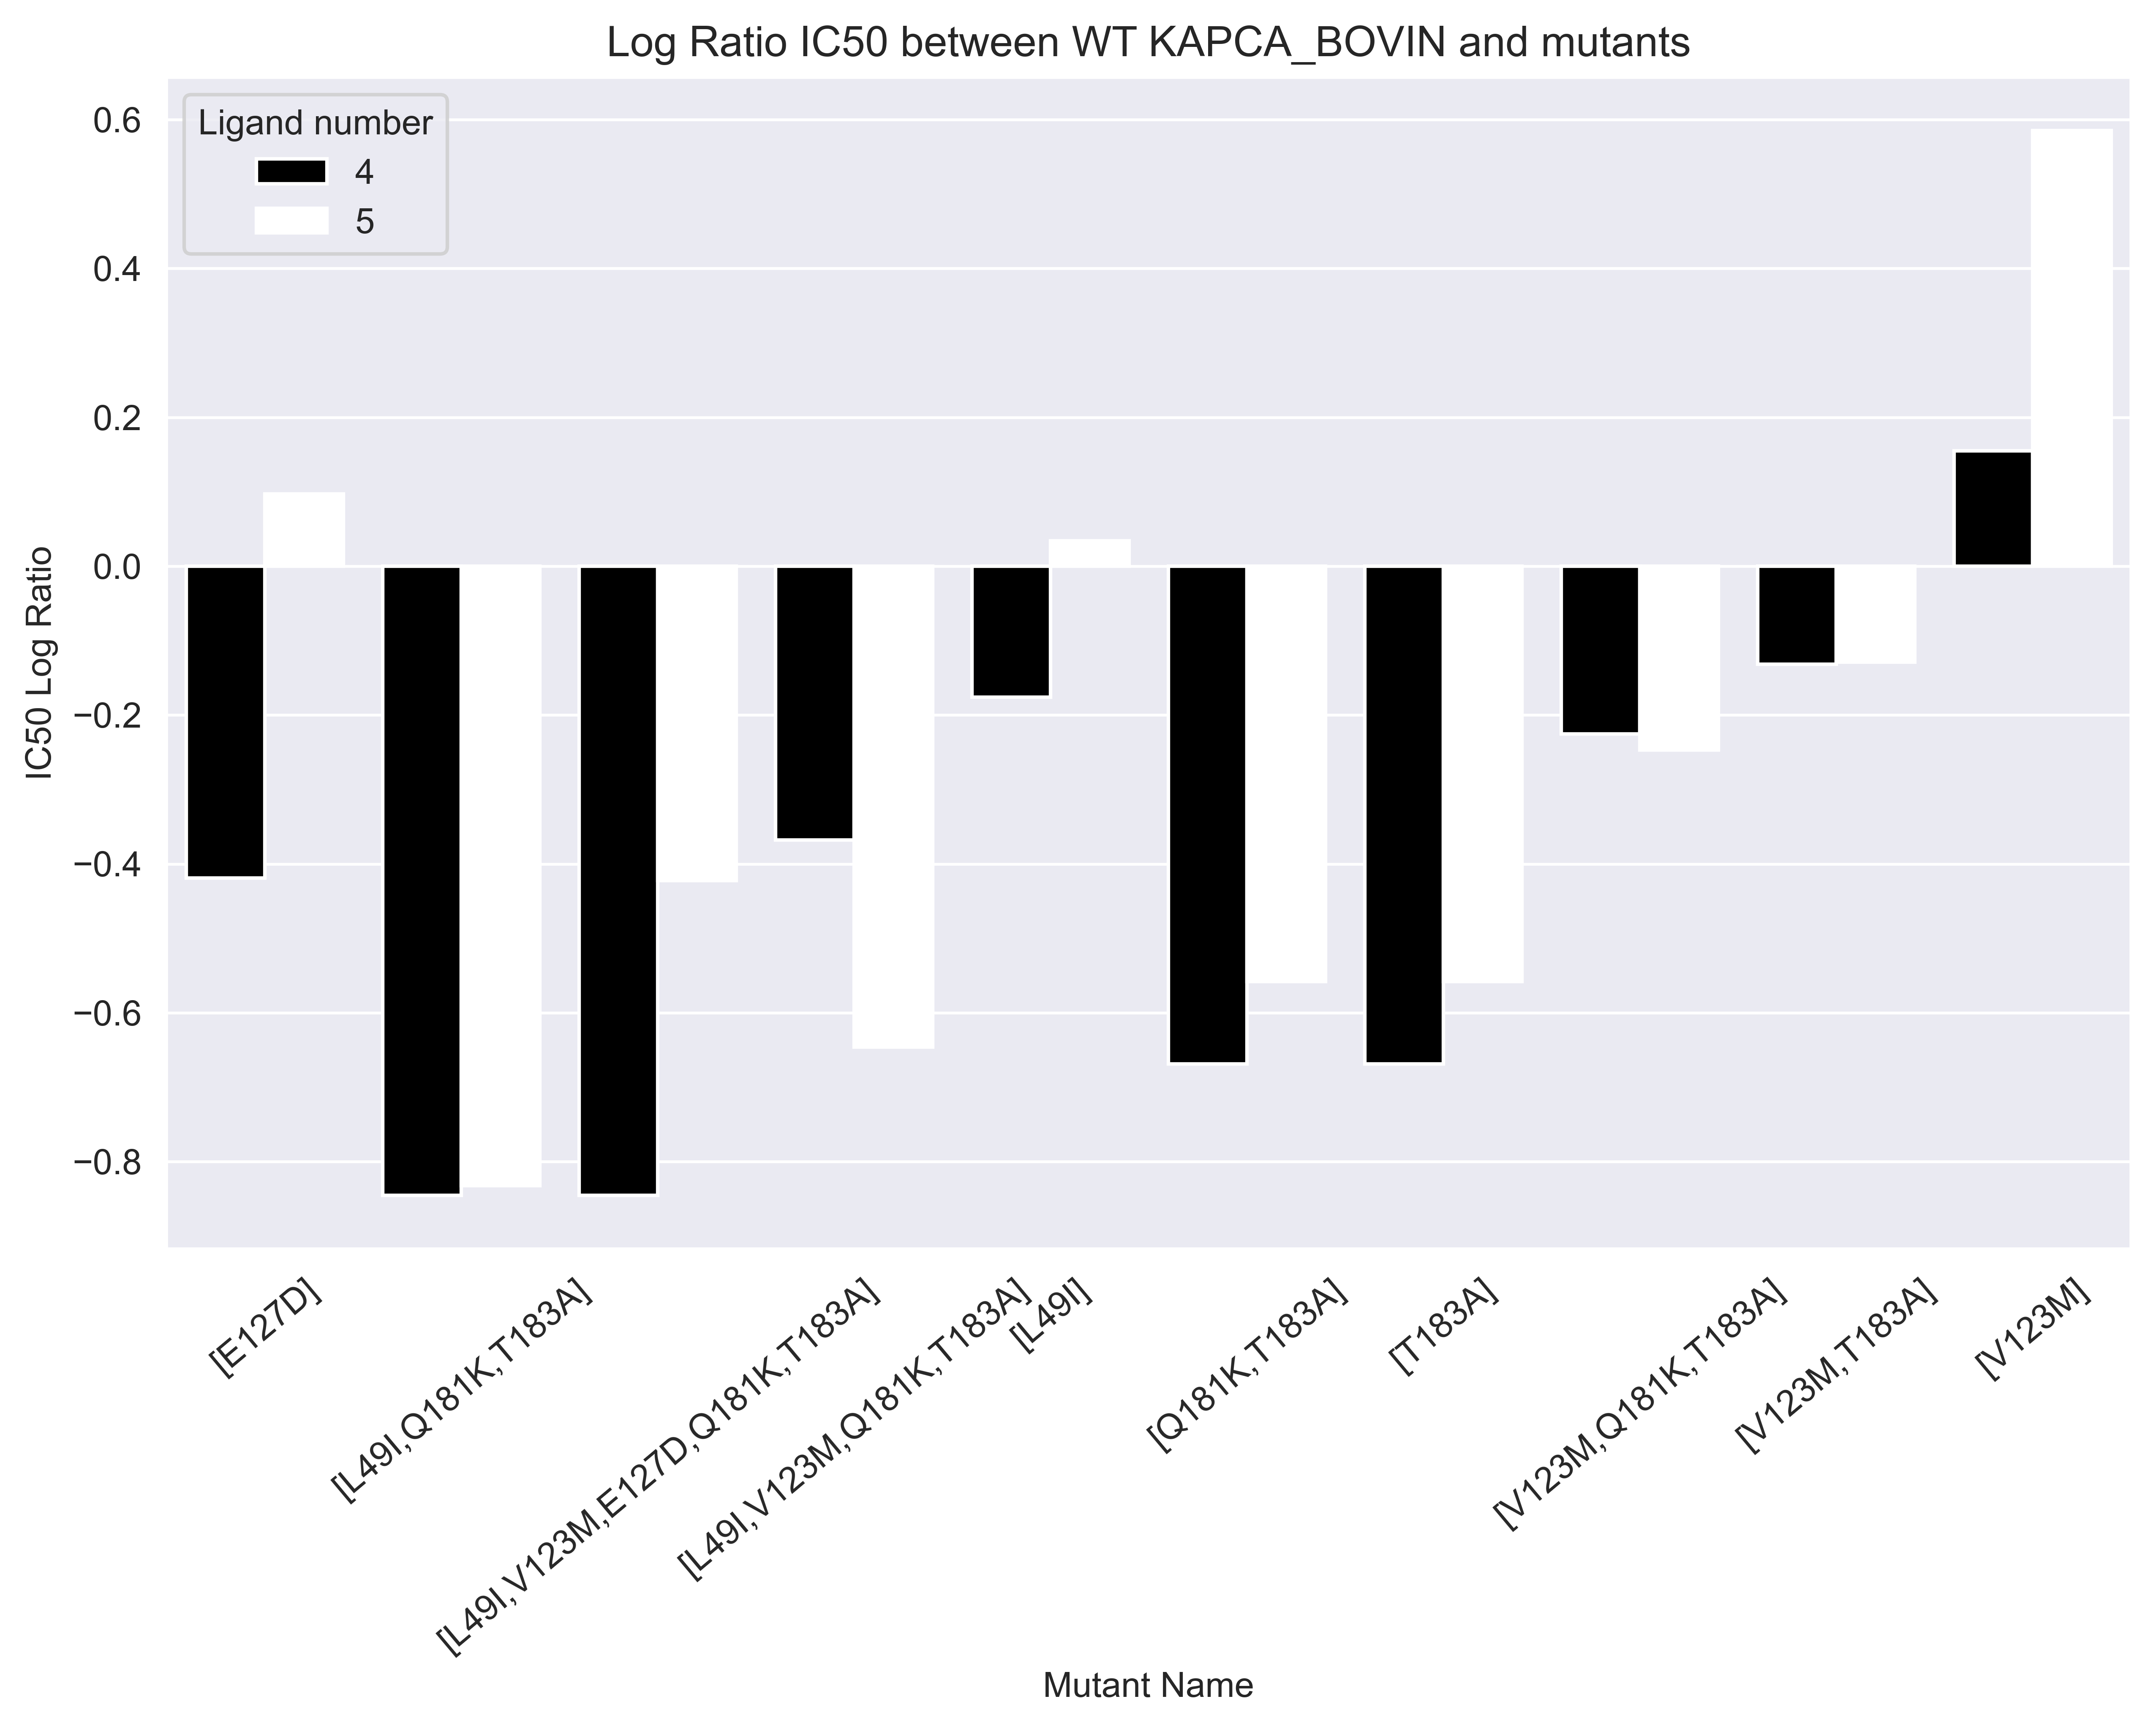

<Figure size 640x480 with 0 Axes>

In [ ]:
for name, group in df_test.groupby('WT protein'):
    plt.close()
    plt.figure(figsize=(10, 6), dpi = 600) 
    sns.set_style("darkgrid")
    sns.barplot(x='Mutant Name', y='IC50 Log Ratio', hue='Ligand number', data=group, errorbar=None, palette='CMRmap')
    plt.title(f'Log Ratio IC50 between WT {name} and mutants')
    plt.xticks(rotation=40)
    plt.show()
    plt.savefig(f'barplot_{name}.png');


In [141]:
fetcher = AlphaFetcher(base_savedir='../data/pdb_files')
ids = pd.read_csv('../data/interaction_pairs.csv')['WT protein'].unique()
print(list(ids))
fetcher.add_proteins(list(ids))

# Retrieve metadata
fetcher.fetch_metadata(multithread=True, workers=4)
# Metadata available at fetcher.metadata_dict

# Commence download of specified files
fetcher.download_all_files(pdb=True, multithread=True, workers=4)

['EGFR_HUMAN', 'KAPCA_BOVIN']


Fetching Metadata: 100%|██████████| 2/2 [00:00<00:00,  7.38it/s]

Uniprot accessions not found in database: KAPCA_BOVIN, EGFR_HUMAN
No valid Uniprot access codes provided


In [214]:
# OLD
amino_acid_dict = {
    'A': 'Alanine',
    'C': 'Cysteine',
    'D': 'Aspartic Acid',
    'E': 'Glutamic Acid',
    'F': 'Phenylalanine',
    'G': 'Glycine',
    'H': 'Histidine',
    'I': 'Isoleucine',
    'K': 'Lysine',
    'L': 'Leucine',
    'M': 'Methionine',
    'N': 'Asparagine',
    'P': 'Proline',
    'Q': 'Glutamine',
    'R': 'Arginine',
    'S': 'Serine',
    'T': 'Threonine',
    'V': 'Valine',
    'W': 'Tryptophan',
    'Y': 'Tyrosine'
}

def convert_aa_names(string):
    if string!='Deletion':
        aa1 = string.split(' -> ')[0]
        aa2 = string.split(' -> ')[1]
        return f'{amino_acid_dict[aa1]} -> {amino_acid_dict[aa2]}'
    else:
        return 'Deletion'

file_directory = 'src/data/pair_dfs'
saving_directory = 'src/plots'

for name in os.listdir(file_directory):
    path = os.path.join(file_directory, name)
    df_pair = pd.read_csv(path)
    df_pair.loc[df_pair.Type == 'gap','Mutation'] = 'Deletion'
    df_pair.Mutation = df_pair.Mutation.apply(convert_aa_names)
    # Creating and Saving IC50 plot
    fig = px.scatter(
        df_pair,
        x='Positions',  # x-axis is the mutation position
        y='IC50',  # y-axis is the IC50 value
        color='Mutant Name',  # color by the mutant name
        hover_name='Mutant Name',
        hover_data={'Positions': True, 'Mutation': True, 'IC50': True, 'Mutant Name':False},  # info to display on hover
        title='IC50 Differences of Mutants by Position',
        labels={'Positions': 'Mutation Position', 'IC50': 'IC50 Difference'},
    )

    # Customize layout if needed
    fig.update_layout(
        hovermode='closest',  # Ensure tooltips show up when hovering closest to a point
        xaxis_title='Mutation Position',
        yaxis_title='IC50 Difference',
        template='plotly_dark'  # Optional: use a dark theme (you can remove or change this)
    )

    # Show the interactive plot
    fig.show()
    saving_path = os.path.join(saving_directory, name.split('.')[0])
    fig.write_html(saving_path + '.html')    

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['Unnamed: 0', 'Mutant Name', 'Positions', 'Colour', 'IC50 Difference', 'IC50 Ratio', 'IC50 Percentage', 'Type', 'Mutation', 'Probability'] but received: IC50

In [90]:
# Probably remove
for name, group in df_mutants[df_mutants['Target Names'].apply(lambda x: len(x)>10)].groupby('WT Target Name'):
    d = {}
    for idx, top_pair in group.iterrows():
        target_names = top_pair['Target Names']
        target_sequences = top_pair['BindingDB Target Chain Sequence']
        d.update(dict(zip(target_names, target_sequences)))

In [ ]:
# Probably remove
def save_to_fasta(group_dict, filename="output.fasta"):
    """
    Saves the protein names and sequences from the dictionary to a FASTA file.
    
    :param group_dict: Dictionary where keys are protein names and values are sequences
    :param filename: Output FASTA file name (default is "output.fasta")
    """
    with open(filename, 'w') as fasta_file:
        for protein_name, sequence in group_dict.items():
            # Write each protein's name and sequence in FASTA format
            fasta_file.write(f">{protein_name}\n")
            # Write the sequence, split into multiple lines if necessary
            for i in range(0, len(sequence), 80):  # 80 characters per line
                fasta_file.write(sequence[i:i+80] + "\n")
    
    print(f"FASTA file saved as {filename}")


In [ ]:
# Probably remove
for name, group in df_mutants[df_mutants['Target Names'].apply(lambda x: len(x)>10)].groupby('WT Target Name'):
    group_dict = {}
    print("-----------------------------------------")
    print('Started processing Group: ', name)
    for idx, top_pair in group.iterrows():
        target_names = top_pair['Target Names']
        target_sequences = top_pair['BindingDB Target Chain Sequence']
        group_dict.update(dict(zip(target_names, target_sequences)))
    
    save_to_fasta(group_dict, f"{name}.fasta")
    print('Finished processing Group: ', name)
    print("-----------------------------------------")

-----------------------------------------
Started processing Group:  Epidermal growth factor receptor
FASTA file saved as Epidermal growth factor receptor.fasta
Finished processing Group:  Epidermal growth factor receptor
-----------------------------------------
-----------------------------------------
Started processing Group:  cAMP-dependent protein kinase catalytic subunit alpha
FASTA file saved as cAMP-dependent protein kinase catalytic subunit alpha.fasta
Finished processing Group:  cAMP-dependent protein kinase catalytic subunit alpha
-----------------------------------------
